# Analysis code

Code for stats + figures.

Run this notebook from the `scripts` folder. Before running, ensure all default
values have been populated with `./scripts/update_param_list_in_model.yaml`.

In [1]:
# for plotting
%matplotlib inline

In [2]:
# imports
import pandas as pd
import seaborn as sns
import seaborn.objects as so
# import statsmodels.api as sm

sns.set_theme()

from exp_utils import *
# from patsy import dmatrices

In [3]:
# load data
df = collate_data()
df.head(10)

,zrc.subset,zrc.speaker_mode,zrc.context_mode,zrc.granularity,zrc.score,zrc.pooling,zrc.seed,zrc.pca_style,feat_type,input_size,...,training.cpc_loss.averaging_penalty,training.best_rq_loss.mask_prob,training.best_rq_loss.mask_width,training.best_rq_loss.codebook_size,training.best_rq_loss.codebook_dim,training.best_rq_loss.offset,training.best_rq_loss.speaker_regex,training.best_rq_loss.prediction_type,training.shuffle,training.max_epochs
0,dev-clean,within,within,triphone,0.1802,none,3459,full,raw,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
1,dev-clean,across,within,triphone,0.2220,none,3459,full,raw,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
2,dev-other,within,within,triphone,0.1853,none,3459,full,raw,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
3,dev-other,across,within,triphone,0.2516,none,3459,full,raw,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
4,test-clean,within,within,triphone,0.1732,none,3459,full,raw,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
5,test-clean,across,within,triphone,0.2124,none,3459,full,raw,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
6,test-other,within,within,triphone,0.1918,none,3459,full,raw,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
7,test-other,across,within,triphone,0.2669,none,3459,full,raw,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
8,dev-clean,within,within,phoneme,0.1129,none,3459,full,raw,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0
9,dev-clean,across,within,phoneme,0.1484,none,3459,full,raw,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0


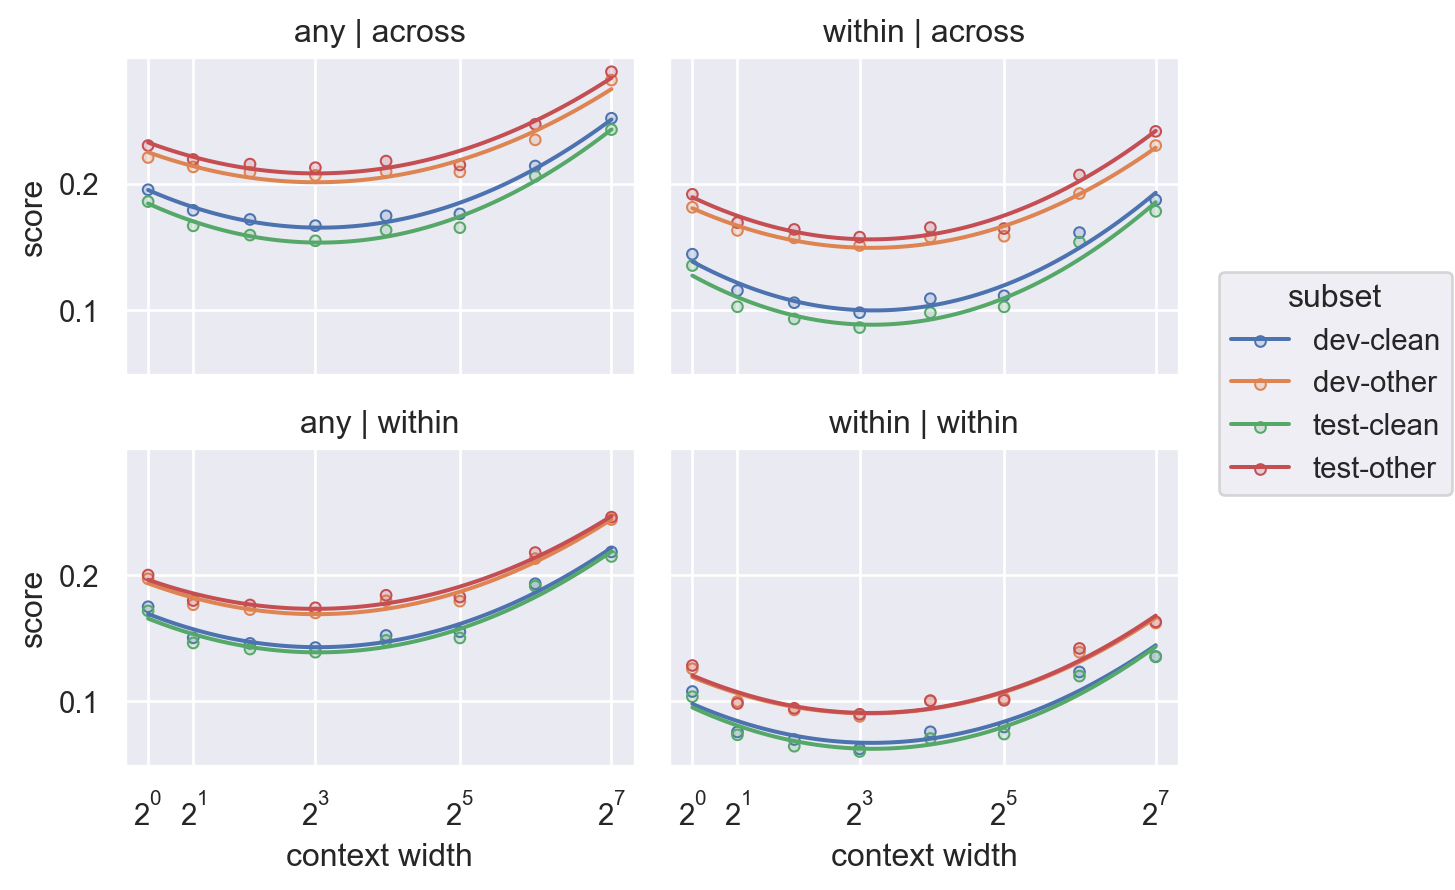

In [4]:
# plot libriABX scores across subsets and context windows w/ phoneme granularity
df_ = filter_data_equal(df, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.cpc_loss.prediction_steps": 12,
    "training.cpc_loss.gutted_steps": 0,
    "training.cpc_loss.negative_samples": 128,
    "training.loss_type": "cpc",
    "zrc.granularity": "phoneme",
    'training.cpc_loss.averaging_penalty': 0,
})
df_ = filter_data_in(
    df_, {"csa.max_width": (float(x) for x in range(1, 129)), "csa.num_layers": (0, 1)}
)
check_data(
    df_,
    "csa.max_width", "zrc.subset", "zrc.score", "zrc.speaker_mode",
    "zrc.context_mode", "training.cpc_loss.offset", "csa.num_layers"
)
plt = (
    so.Plot(df_, x="csa.max_width", y="zrc.score", color="zrc.subset")
    .facet(row="zrc.speaker_mode", col="zrc.context_mode")
    .add(so.Dots())
    .add(so.Line(), so.PolyFit())
    .scale(
        x=so.Continuous(trans="symlog").tick(at=[1, 2, 8, 32, 128]).label(base=2)
    )
    .label(x="context width", y="score", color="subset")
)
plt.save('../resources/libriabx_context_subset_phoneme.pdf')

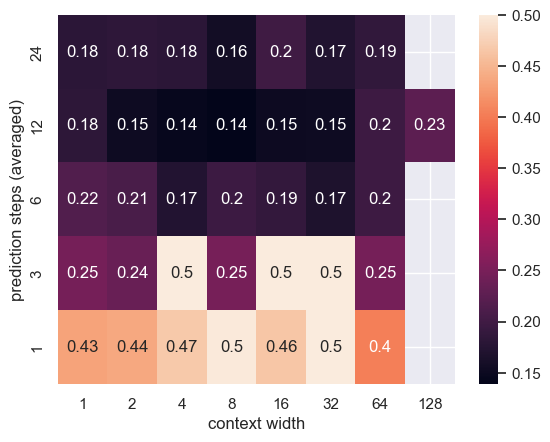

In [5]:
# plot avg. libriABX score of context width vs prediction steps
df_ = filter_data_equal(df, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    "training.cpc_loss.gutted_steps": 0,
    'training.cpc_loss.averaging_penalty': 0,
    "csa.dim_feedforward": 1024,
})
df_ = filter_data_in(
    df_, {"csa.max_width": (float(x) for x in range(1, 129)), "csa.num_layers": (0, 1)}
)
check_data(
    df_,
    "csa.max_width", "zrc.subset", "zrc.score", "zrc.speaker_mode",
    "zrc.context_mode", "training.cpc_loss.offset", "csa.num_layers",
    "training.cpc_loss.prediction_steps", "zrc.granularity",
    "training.cpc_loss.negative_samples",
)
df_ = df_.pivot_table(
    columns="csa.max_width",
    index="training.cpc_loss.prediction_steps",
    values="zrc.score"
).sort_values(by='training.cpc_loss.prediction_steps', ascending=False)
plt = sns.heatmap(df_, annot=True)
plt.set(xlabel='context width', ylabel='prediction steps (averaged)')
plt.set_xticklabels([f'{int(x):d}' for x in sorted(df_.columns)])
plt.set_yticklabels([f'{int(x):d}' for x in sorted(df_.index, reverse=True)])
plt.get_figure().savefig("../resources/libriabx_prediction_steps_vs_width.pdf")

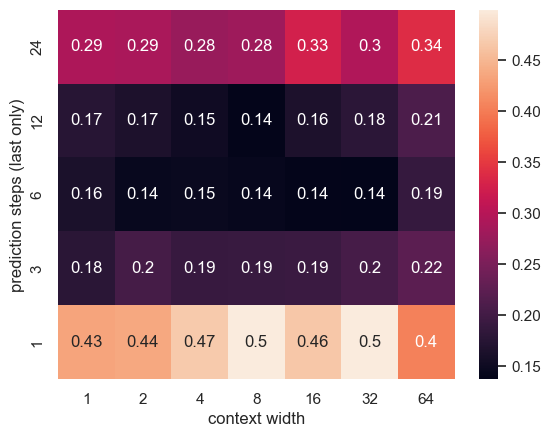

In [6]:
# plot avg. libriABX score of context width vs prediction steps
df_ = filter_data_equal(df, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    # 'training.cpc_loss.averaging_penalty': 0,
})
df_ = filter_data_in(
    df_, {"csa.max_width": (float(x) for x in range(1, 129)), "csa.num_layers": (0, 1)}
)
idx = df_['training.cpc_loss.prediction_steps'] == 1
for n in range(2, 25):
    idx |= (df_['training.cpc_loss.prediction_steps'] == n) & (df_['training.cpc_loss.gutted_steps'] == (n - 1))
df_ = df_.loc[idx]
check_data(
    df_,
    "csa.max_width", "zrc.subset", "zrc.score", "zrc.speaker_mode",
    "zrc.context_mode", "training.cpc_loss.offset", "csa.num_layers",
    "training.cpc_loss.prediction_steps", "zrc.granularity",
    "training.cpc_loss.negative_samples", "training.cpc_loss.gutted_steps"
)
df_ = df_.pivot_table(
    columns="csa.max_width",
    index="training.cpc_loss.prediction_steps",
    values="zrc.score"
).sort_values(by='training.cpc_loss.prediction_steps', ascending=False)
plt = sns.heatmap(df_, annot=True)
plt.set(xlabel='context width', ylabel='prediction steps (last only)')
plt.set_xticklabels([f'{int(x):d}' for x in sorted(df_.columns)])
plt.set_yticklabels([f'{int(x):d}' for x in sorted(df_.index, reverse=True)])
plt.get_figure().savefig("../resources/libriabx_prediction_steps_vs_width_one.pdf")